# Task

**Claim1 : 해당 광고가 소비자들의 지출을 늘리는데 성공적으로 기여하는가?**

**Claim2 : 고객을 Segmentation하라!**

## 고객을 아래 4집단으로 구분하여 광고의 효과를 극대화하려고 한다.

1. Persuadables : 광고를 통해 실제 그 효과를 거둘 수 있는 고객
2. Sure things : 광고를 하지 않아도 해당 제품을 소비하는 고객
3. Lost cause : 광고여부에 관계없이 소비를 하지 않는 고객
4. Sleeping dogs : 광고를 할 경우 오히려 소비를 하지 않는 고객


-> 중요한 것은 Persuadables와 Sleeping dogs를 정확하게 구별해내는 것이다. 왜냐하면 Sure things와 Lost Cause는 광고에 큰 영향을 받지 않으나 나머지 두 집단은 광고에 영향을 크게 받기 때문이다. 물론 4고객을 정확하게 분류하여 Persuadables에게만 광고를 보내는 것이 제일 효율적이나 실제 모델의 오차 등을 고려했을 때, Sleeping dogs를 가려내는 것이 가장 중요한 Task가 될 것이다.

# uplift scoring을 이용한 Custromer Segmentation 

In [ ]:
!pip install pyuplift

# Hilstrom Data

**Hillstrom dataset**<br>  
이 데이터 셋은 남자 머천다이저가 제안한 이메일 광고를 받은 사람, 여자 머천다이저가 제안한 이메일 광고를 받은 사람, 아무런 광고를 받지 못한 사람으로 분류되서 각 사람들의 feature랑 웹사이트 방문 횟수 등이 있는 데이터 셋입니다. <br>이를 통해 광고가 효과가 있는지, 어떤 머천다이저가 보낸 광고가 효과가 있는지 여부를 알 수 있는 데이터셋입니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyuplift.datasets import load_hillstrom_email_marketing

df = load_hillstrom_email_marketing()

In [ ]:
 df.keys()

dict_keys(['description', 'data', 'feature_names', 'treatment', 'target', 'target_spend', 'target_visit', 'target_conversion'])

In [ ]:
display(df['data'])
display(df['feature_names'])

array([[ 10.  , 142.44,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  6.  , 329.08,   1.  , ...,   0.  ,   0.  ,   1.  ],
       [  7.  , 180.65,   0.  , ...,   0.  ,   0.  ,   1.  ],
       ...,
       [  6.  ,  29.99,   1.  , ...,   0.  ,   1.  ,   0.  ],
       [  1.  , 552.94,   1.  , ...,   1.  ,   0.  ,   0.  ],
       [  1.  , 472.82,   0.  , ...,   0.  ,   0.  ,   1.  ]])

array(['recency', 'history', 'mens', 'womens', 'newbie', 'zip_code_Rural',
       'zip_code_Surburban', 'zip_code_Urban',
       'history_segment_$0 - $100', 'history_segment_$1,000 +',
       'history_segment_$100 - $200', 'history_segment_$200 - $350',
       'history_segment_$350 - $500', 'history_segment_$500 - $750',
       'history_segment_$750 - $1,000', 'channel_Multichannel',
       'channel_Phone', 'channel_Web'], dtype='<U29')

## Dataset Decription

**Feature Dataset**

1. Recency : 가장 최근 결제가 발생했던 월
2. History : 지난해 실제 지출했던 금액($)
3. Newbie : 지난해 처음 가입한 고객인지 (1: Newbie)
4. Zip_code : 시골,근교,도시로 구분
5. History_segment : 지난해 지출한 금액을 기준으로 분류
6. Channel : 지난해 결제를 진행한 수단(Phone : 스마트폰앱을 통해 / Web : 웹을 통해 / Multi : 섞여있음)
7. Treatment : 처치 (1: 남성용 상품에 대한 광고가 적힌 이메일을 받은 집단 / 2: 여성용 상품에 대한 광고가 적힌 이메일을 받은 집단 / 0: 아무런 광고를 받지 못한 집단(Control Group))
8. Man / woman : 고객이 작년에 남성/여성 상품을 구매를 한 여부. (0 / 1)

In [ ]:
cols = list(df['feature_names'])
data_feature = pd.DataFrame(df['data'],columns=cols)

data_feature['treatment'] = df['treatment']
data_feature

,recency,history,mens,womens,newbie,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_$0 - $100,"history_segment_$1,000 +",history_segment_$100 - $200,history_segment_$200 - $350,history_segment_$350 - $500,history_segment_$500 - $750,"history_segment_$750 - $1,000",channel_Multichannel,channel_Phone,channel_Web,treatment
0,10.0,142.44,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
1,6.0,329.08,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,7.0,180.65,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
3,9.0,675.83,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,2.0,45.34,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10.0,105.54,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
63996,5.0,38.91,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
63997,6.0,29.99,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
63998,1.0,552.94,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2


**Target Dataset**

1. target_spend : 해당 광고가 있은 후 2주 사이 지출금액
2. target_visit : 해당 광고가 있은 후 2주 사이 웹사이트에 방문했는지 (1: 방문 / 0: 방문x)
3. target_conversion : 해당 광고가 있은 후 2주 사이 광고가 된 상품을 구매했는지 (1: 구매 / 0: 구매x)

In [ ]:
cols_target = ['target_spend','target_visit','target_conversion']
array_target = np.vstack((df['target_spend'],df['target_visit'],df['target_conversion'])).T
data_target = pd.DataFrame(array_target,columns=cols_target)
data_target

,target_spend,target_visit,target_conversion
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
63995,0.0,0.0,0.0
63996,0.0,0.0,0.0
63997,0.0,0.0,0.0
63998,0.0,0.0,0.0


In [ ]:
dataset = pd.concat([data_feature,data_target],axis=1)

## Model Description

**UpLift Model**


이상적인 세계에서 우리는 각각의 개인을 그들의 "유형"으로 식별할 수 있을 것이고, 우리는 소위 " 설득 가능한" 사람들만을 목표로 할 것이다. 
왜냐하면 이곳이 우리가 투자 수익을 가장 많이 얻을 수 있는 곳이기 때문이다. 
그리고 우리는 분명히 "잠자는 개들"을 목표로 하고 싶지 않을 것이다. 
현실적으로 우리는 한 개인이 어떤 사람인지 발견하기를 바랄 수 없다. 
그들에게 오직 한 가지 treatment만을 보여줄 수 있기 때문이다.
대신, "비슷한 사람들"의 집단이 평균적으로 어떤 일을 할 것인지 알려주기 위해 통계와 기계 학습을 이용할 수 있다.

각 개인은 -1에서 1 사이의 lift 점수를 받고, 이 점수를 사용하여 누구를 타깃으로 할지 결정한다. 
정확한 모델이 있다면 양성 점수가 높은 사람이 치료에 더 잘 반응할 것이므로 표적이 되어야 하는 반면, 
음성 점수가 낮은 사람은 반응이 나쁘므로 표적이 되어서는 안 된다.

# Preprocessing and EDA

## Preprocessing

각각의 성별에 대한 구매 전환률을 확인하게 위해 작년에 둘 다(두 개의 성별) 구매한 경우를 삭제해주도록 한다.

**1) mens와 womens가 모두 1.0인 사람들은 제거**

In [ ]:
idx_lst = []
for i in range(len(dataset)):
    if dataset['mens'].iloc[i] == 1.0 and dataset['womens'].iloc[i] == 1.0:
        idx_lst.append(i)

dataset.drop(idx_lst,axis=0,inplace=True)
# 행 삭제

final_dataset = dataset.reset_index().drop('index',axis=1)

In [ ]:
final_dataset

,recency,history,mens,womens,newbie,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_$0 - $100,"history_segment_$1,000 +",...,history_segment_$350 - $500,history_segment_$500 - $750,"history_segment_$750 - $1,000",channel_Multichannel,channel_Phone,channel_Web,treatment,target_spend,target_visit,target_conversion
0,10.0,142.44,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,0.0,0.0,0.0
1,7.0,180.65,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0.0,0.0,0.0
2,9.0,675.83,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0
3,2.0,45.34,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0.0,0.0,0.0
4,6.0,134.83,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57547,10.0,105.54,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0
57548,5.0,38.91,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0
57549,6.0,29.99,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0
57550,1.0,552.94,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,2,0.0,0.0,0.0


In [ ]:
dataset

,recency,history,mens,womens,newbie,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_$0 - $100,"history_segment_$1,000 +",...,history_segment_$350 - $500,history_segment_$500 - $750,"history_segment_$750 - $1,000",channel_Multichannel,channel_Phone,channel_Web,treatment,target_spend,target_visit,target_conversion
0,10.0,142.44,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,0.0,0.0,0.0
2,7.0,180.65,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0.0,0.0,0.0
3,9.0,675.83,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0
4,2.0,45.34,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2,0.0,0.0,0.0
5,6.0,134.83,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10.0,105.54,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0
63996,5.0,38.91,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0
63997,6.0,29.99,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0
63998,1.0,552.94,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,2,0.0,0.0,0.0


In [ ]:
len(final_dataset)

57552

## EDA

**분포**

<ipython-input-11-ca557713cbcc>:27: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  axes[i][j].pie(ratio_lst,labels=label,autopct='%.1f%%',startangle=260,counterclock=False,


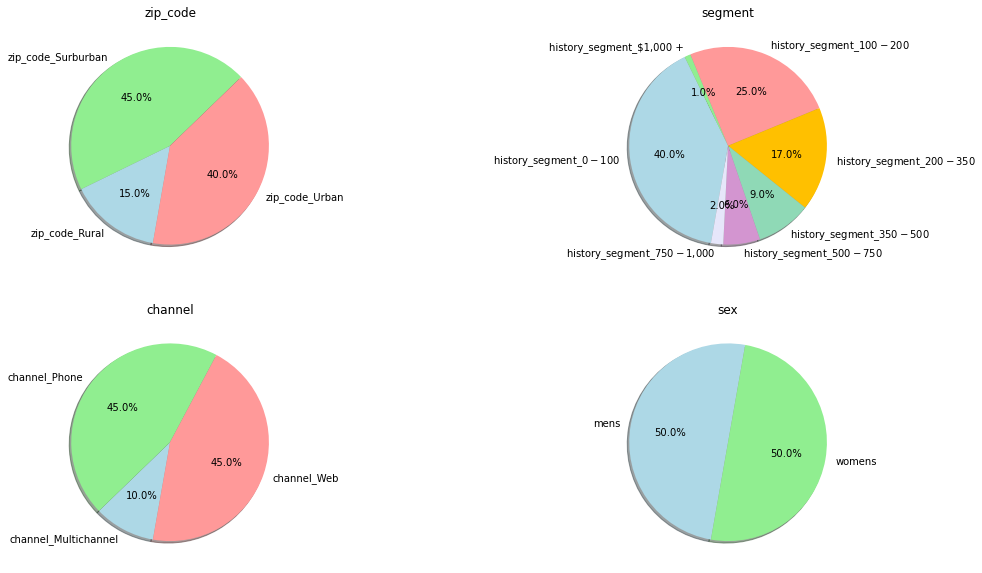

In [ ]:
zip_code = ['zip_code_Rural','zip_code_Surburban','zip_code_Urban']
segment = ['history_segment_$0 - $100',
       'history_segment_$1,000 +', 'history_segment_$100 - $200',
       'history_segment_$200 - $350', 'history_segment_$350 - $500',
       'history_segment_$500 - $750', 'history_segment_$750 - $1,000']

channel = ['channel_Multichannel', 'channel_Phone', 'channel_Web']
sex = ['mens', 'womens']

pie_lst = [zip_code,segment,channel,sex]
pie_title = ['zip_code','segment','channel','sex']

def get_pie_info(df,col):
    ratio_lst = []
    for i in col:
        ratio = round(np.sum(df[i]/len(df)),2)
        ratio_lst.append(ratio)
    label = col
    return ratio_lst,label
    
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

for num in range(4):
    i = num//2
    j = num%2
    ratio_lst,label = get_pie_info(final_dataset,pie_lst[num])
    axes[i][j].pie(ratio_lst,labels=label,autopct='%.1f%%',startangle=260,counterclock=False,
       shadow = True, colors = ['lightblue','lightgreen','#ff9999',
                                '#ffc000','#8fd9b6','#d395d0','lavender'])
    axes[i][j].set_title(pie_title[num])

plt.subplots_adjust(wspace=1)
plt.show()

<AxesSubplot:xlabel='newbie', ylabel='count'>

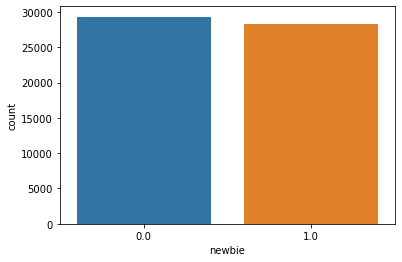

In [ ]:
sns.countplot(x='newbie', data=final_dataset)

<AxesSubplot:xlabel='recency', ylabel='count'>

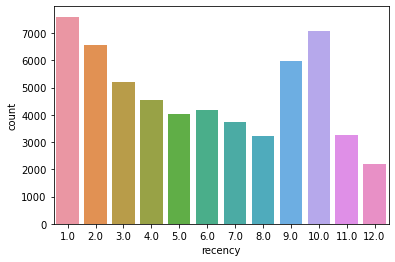

In [ ]:
sns.countplot(x="recency",data=final_dataset)

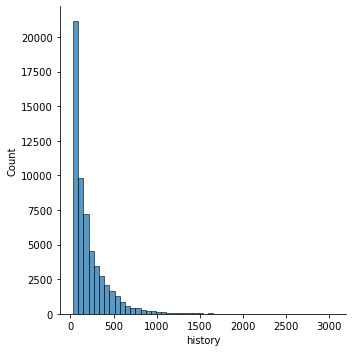

In [ ]:
sns.displot(x="history",data=final_dataset, bins=50)

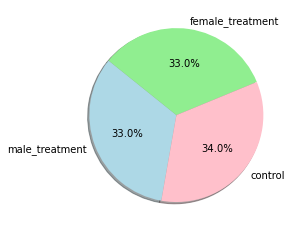

In [ ]:
ratio_lst = []
ratio_1 = round(dataset['treatment'].value_counts()[1]/len(final_dataset),2)
ratio_2 = round(dataset['treatment'].value_counts()[2]/len(final_dataset),2)
ratio_lst.append(ratio_1)
ratio_lst.append(ratio_2)
ratio_lst.append(1-ratio_1-ratio_2)

plt.pie(ratio_lst,labels=['male_treatment','female_treatment','control'],autopct='%.1f%%',startangle=260,counterclock=False,
       shadow = True, colors = ['lightblue','lightgreen','pink'])
plt.show()

**각 처치(Treatment당 target들의 값들이 어떻게 변했는지 막대그래프를 통해 알아보도록 하자** <br>
Treatment : 처치 <br>
(1: 남성용 상품에 대한 광고가 적힌 이메일을 받은 집단 / 2: 여성용 상품에 대한 광고가 적힌 이메일을 받은 집단 / 0: 아무런 광고를 받지 못한 집단(Control Group))

# Modeling

**위 EDA에서 알 수 있듯, 데이터 셋 내의 각 집단의 분포가 모두 동일하게 나타나고 있습니다!**<br>
**이 경우 이 데이터 셋은 random Clinical Trial(랜덤 실험)으로 진행되어 각 집단이 Homogeneous(균일) 성질을 만족하는 것을 알수 있습니다**

1. 각 처치(Treatment)와 그에 대한 Target 변수들이 독립임을 알 수 있고,
2. 0<P(Z=1|X)<1 을 만족함을 알 수 있습니다. <br> (이 의미는 Feature가 주어졌을 때 처치가 어느 한쪽으로 치우쳐져 있지 않음을 의미합니다. <br> 즉, 남성(men=1) 모두에게 처치가 가해져 있지 않다. 데이터셋 내 집단에게 균등하게 처치가 이루어 졌다. 이런 식으로 이해하면 될 것 같습니다.)

이 __두가지 조건__ 을 만족하면 우리는 Strong Ignorability Assumption이 만족하였다고 합니다.<br>
이 것을 만족한다면 일반적인 상관관계를 통해서도 인과관계를 추론할 수 있게 됩니다.<br>
또한 단순 집단 간의 평균의 차이를 구해 처치(Treatment)가 어떠한 차이를 만들어내는지 계산할 수 있게 됩니다.
<br>
하지만 만일 위의 조건이 만족하지 않는다면, 처치(Treatment)와 결과(Target)에 모두 영향을 주는 교란변수(Confounder)를 도메인 지식으로 찾아내야 합니다. 가령 아래 데이터 셋으로 예를 들면 History가 높은 사람에게는 광고 메일을 보내지 않았고, Recency가 오래된 고객들에게는 광고 메일을 보낸 분포가 나왔다면 History와 Recency가 교란 변수가 되고, 이 교란변수를 조건부로 하여 교란변수의 효과를 상쇄시킨 뒤 차이를 계산하는 CATE(Conditional Average Treatment Estimation)을 진행해야 하며 이 과정은 꽤나 복잡합니다. 
<br>이는 Heterogeneous한 집단에서 인과관계를 추론하는 방식이며 저희 데이터셋은 Homogeneous하므로 해당은 되지 않습니다. 
<br>
CATE를 추정하는 방식을 간략하게 설명하면 다음과 같습니다. 

1. Counfounders를 찾아낸 뒤 이를 조건부로 하여 처치(Treatment)를 받을 확률을 계산합니다. <br> (P(Z=1|X) where Z : Treatment, X : Confounders)
2. 우리는 이를 Propensity Score(경향성 점수)라고 합니다. 경향성 점수를 사용하는 이유는 교란변수를 조건부로 두었기에 교란변수의 영향을 상쇄시킬 수 있기 때문입니다. 
3. 또한, Propensity Score를 input으로 하고, 우리가 관측한 결과(여기에서는 Target값들 즉, Target visit, spend, Conversion이 됩니다.)를 Target으로 하는 Response Function을 추정합니다. 
4. 이 때 머신러닝 알고리즘이 사용됩니다. 주로 트리 기반으로 분류 알고리즘인 XGBoost, LightGBM, RandomForest 등이 사용되며 적용되는 방법은 3가지가 있습니다 <br>
<ul>
<li>T-Learner : Two-model method라고 불리며, treatment를 받은 집단과 그렇지 않은 집단을 다른 모델로 학습하여 각각의 Treatment Effect를 계산하여 그 차이를 계산합니다.</li>
<li>S-Learner : One -model method라고 불리며, 하나의 모델로 학습을 한 뒤 treatment를 받은 집단과 그렇지 않은 집단으로 나누어 Treatment Effect를 계산하여 그 차이를 계산합니다. </li>
<li>X-Learner : Two-model로 우선 학습을 한 뒤 treatment를 받은 집단과 그렇지 않은 집단을 Cross하여 결과를 예측하여 가상의 예측값을 추론합니다. 그리고 개개인의 Treatment Effect를 계산하여 그 차이를 평균하여 CATE를 계산합니다.</li>
</ul><br>
5. 우리는 이 과정을 통해 동질하지 않은 집단에서 광고가 효과가 있었는지 그 효과를 추정한다고 합니다
6. 즉. 우리 데이터셋은 랜덤실험을 만족하는 Homogeneous한 셋이기 때문에 위 과정을 거치지 않고 평균의 차이를 계산하여 광고의 효과를 알아낼 수 있습니다. <br> 다만 ATE 적용 후, S-Learner과 유사하게 하나의 머신러닝 알고리즘 모델로 학습해서 Treatment를 받은 집단과 그렇지 않은 집단을 나눠 광고 집행(Treatment) 효과를 알아볼 예정입니다. 

<참조 : Metalearners for estimating heterogeneous treatment effects using machine learning (Sören R. Künzel , Jasjeet S. Sekhon , Peter J. Bickel , Bin Yu. 2019)>

## ATE(Average Treatment Estimation)

간단하게 설명하면, 광고를 보여줬을 때와 그렇지 않았을 때 광고의 효과를 계산하는데 있어서 가장 좋은 방법은 같은 사람에게 광고를 보여주기도 하고, 보여주지도 않은 채 각각의 개인들의 차이를 계산하는 것입니다. 그러나 이는 현실적으로 불가능하므로, 각각의 집단의 평균을 계산하여 차이를 통해 광고의 효과를 알아보게 됩니다. 

이때 중요한 점은 Random하게 집단을 나누어 Treatment(여기서는 광고)를 처치하는 것입니다. 그렇지 않으면 교란변수가 작용하여 결과를 신뢰하지 못하게 됩니다. 데이터셋 설명에 Random하게 집단을 구분하였다고 명시하였기에 교란변수의 작용은 생각하지 않겠습니다.

광고를 받은 집단(Treatment = 1,2)과 그렇지 않은 집단(Treatment = 0)의 conversion된 소비 지출의 평균의 차이를 계산합니다. 그리고 그 차이를 ATE라고 합니다.

이 차이가 통계적으로 유의미한지 안한지는 일단 논의하지 않는 것으로 하겠습니다.

<br>

**먼저 바플롯을 이용해 각 성별당 구매 전환율을 확인해보고 ATE를 계산하여 그 수치를 비교해보도록 하겠습니다**

<AxesSubplot:xlabel='mens', ylabel='target_conversion'>

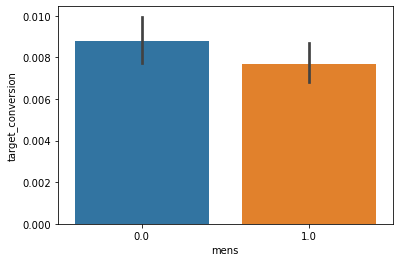

In [ ]:
sns.barplot(x = 'mens', y = 'target_conversion', data = final_dataset)

<AxesSubplot:xlabel='womens', ylabel='target_conversion'>

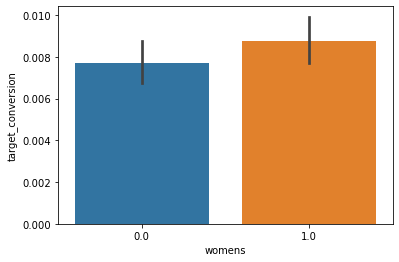

In [ ]:
sns.barplot(x = 'womens', y = 'target_conversion', data = final_dataset)

__시각화 결과 남성보다 여자의 경우 구매 전환율(1) 비중이 더 높은 것이 확인되었다.__

<AxesSubplot:xlabel='treatment', ylabel='target_conversion'>

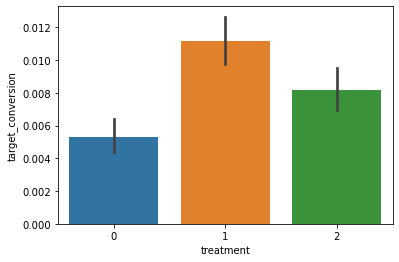

In [ ]:
sns.barplot(x = 'treatment', y = 'target_conversion', data = final_dataset)

<AxesSubplot:xlabel='treatment', ylabel='target_spend'>

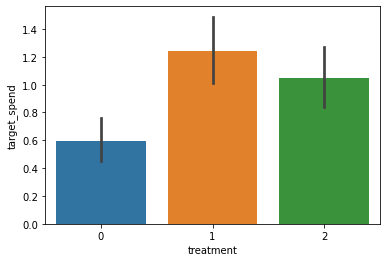

In [ ]:
sns.barplot(x = 'treatment', y = 'target_spend', data = final_dataset)

<AxesSubplot:xlabel='treatment', ylabel='target_visit'>

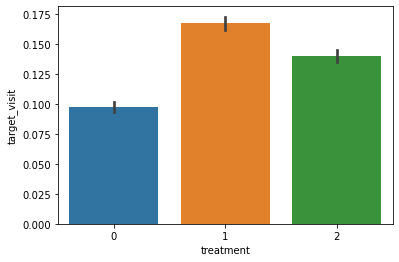

In [ ]:
sns.barplot(x = 'treatment', y = 'target_visit', data = final_dataset)

ATE를 적용하지 않은 데이터에 시각화를 한 결과 처치(1: 남성 용품)의 경우가 여성용품(Treatment:2)보다 <br>
광고 시 더 높은 구매 전환율, 소비금액, 방문율을 보여주는 것을 알 수 있습니다. <br>
그렇다면 ATE를 적용 후 산출된 수치로 비교해보도록 하겠습니다

In [ ]:
def cal_uplift(df):
    # 광고를 받은 집단과 그렇지 않은 집단 간의 물품구매가 있었냐 없었냐의 차이를 계산합니다.
    # 각 처치에 해당하는 구매 전환 수를 계산 (합계)
    male_conv = df[df.treatment == 1]['target_conversion'].sum()
    female_conv = df[df.treatment == 2]['target_conversion'].sum()
    control_conv = df[df.treatment == 0]['target_conversion'].sum()
    
    # 이후 계산을 위해 평균을 계산합니다.
    male_conv_mean = df[df.treatment == 1]['target_conversion'].mean()
    female_conv_mean = df[df.treatment == 2]['target_conversion'].mean()
    control_conv_mean = df[df.treatment == 0]['target_conversion'].mean()
    
    # 차이 계산(횟수)
    # ate 계산 : 실험군 평균 - 통제 변수(처치를 받지 못한) 평균 
    male_conv_ate = male_conv_mean - control_conv_mean
    female_conv_ate = female_conv_mean - control_conv_mean
    
    # 평균의 차이 계산(이는 광고를 받은 집단이 평균적으로 얼마나 더 많이 샀냐를 표현하는 지표입니다)
    # 위에 거랑 똑같은 거 
    male_conv_mean = male_conv_mean - control_conv_mean
    female_conv_mean = female_conv_mean - control_conv_mean
    
    # 광고를 받은 집단과 그렇지 않은 집단 간의 사이트 방문횟수의 차이를 계산합니다.
    # 방문 수에 대한 평균의 합산을 계산합니다. 
    male_visit = df[df.treatment == 1]['target_visit'].mean()
    female_visit = df[df.treatment == 2]['target_visit'].mean()
    control_visit = df[df.treatment == 0]['target_visit'].mean()
    
    # ate 계산 실험군 평균 - 통제 변수 평균 
    male_visit_ate = male_visit - control_visit
    female_visit_ate = female_visit - control_visit
    

    # (남성/여성) 평균 전환량 차이 (ate) * (남성/여성) 상품 전환량
    
    male_order = male_conv_mean*len(df[df.treatment == 1]['target_conversion'])
    female_order = female_conv_mean*len(df[df.treatment == 2]['target_conversion'])
    
    # 평균 타겟 소비량 평균 
    male_avg_spend = df[df.treatment==1]['target_spend'].mean()
    female_avg_spend = df[df.treatment==2]['target_spend'].mean()
    
    # 각 집단에 속한 사람들의 평균 Conversion의 차이에 각 집단이 속한 사람들이 평균적으로 
    # 지출한 금액을 곱해 광고를 받은 집단이 얼마나 더 많은 지출을 하였는지 계산합니다.
    
    male_spend_ate = male_order*male_avg_spend
    female_spend_ate = female_order*female_avg_spend
    
    print(f"Male E-mail Conversion ATE : {male_conv_ate:.03f}")
    print(f"Male E-mail Visit ATE : {male_visit_ate :.03f}")
    print(f"Male E-mail Spend ATE : ${male_spend_ate :.03f}")
    
    print("---------------------------------------------------------------")

    print(f"Female E-mail Conversion ATE : {female_conv_ate:.03f}")
    print(f"Female E-mail Visit ATE : {female_visit_ate :.03f}")
    print(f"Female E-mail Spend ATE : ${female_spend_ate :.03f}")

In [ ]:
cal_uplift(final_dataset)

Male E-mail Conversion ATE : 0.006
Male E-mail Visit ATE : 0.070
Male E-mail Spend ATE : $139.327
---------------------------------------------------------------
Female E-mail Conversion ATE : 0.003
Female E-mail Visit ATE : 0.043
Female E-mail Spend ATE : $58.068


결과를 해석하자면 남성상품에 대한 광고를 받은 집단은 아무런 광고를 받지 않은 집단보다 광고된 상품을 평균적으로 0.6% 더 많이 구매를 하였고, 7%정도 더 많이 사이트에 방문하였으며, 139.327달러를 더 많이 지출한 것을 의미합니다.

여성상품에 대한 광고를 받은 집단 역시 그렇지 않은 집단보다 광고된 상품을 0.3% 더 많이 구매하였고, 4.256% 정도 더 많이 사이트에 방문하였으며, 58달러를 더 많이 지출한 것을 의미합니다.

시각화와 ATE 결과를 통해 광고 전 단순 각 성별 집단 내 구매전환율 비중이 높다고 소비 금액이 높은 것이 아니며 남성의 경우 광고의 효과가 더 높은 것을 확인할 수 있었습니다.

## Multi-Classification Model for Predicting the Uplift Score

이제 customer segmentation을 할 차례입니다. 

우선 고객을 4가지 범주로 Label encoding하게 됩니다.


1. 광고를 받았고, 광고된 상품을 구매한 고객 - 0
2. 광고를 받았으나 광고된 상품을 구매하지 않는 고객 - 1
3. 광고를 받지 않았고, 광고된 상품을 구매한 고객 - 2
4. 광고를 받지 않았고, 광고된 상품을 구매하지 않은 고객 - 3


논의의 편의를 위해 Male,Female 상품에 대한 광고를 받은 사람을 1로 묶고, 그렇지 않은 사람들을 0으로 묶겠습니다. <br>이때 두 집단 간의 비율의 차이가 발생하지만 이는 무시하겠습니다.

우리가 사용하게 될 모델은 Uplift Modeling으로 Uplift Score를 산출하여 고객을 Segmentation하는 방식입니다.

**Uplift Score = P(Persuadables) + P(Lost Caues) - P(Sure things) - P(sleeping dogs)** 이며,<br>
직관적인 설명은 광고를 진행하였을 때 구매를 진행할 확률에서 광고를 진행하지 않아도 살 확률과 광고를 진행해도 매몰되는 소비자군일 확률을 차감한 것입니다. <br>-1에서 1사이로 측정되며 그 값이 클수록 광고효과가 큰 고객이 됩니다

Reference : Radcliffe, N.. “Using control groups to target on predicted lift: Building and assessing uplift model.” (2007).

**광고가 효과가 있냐 없냐를 보는 것**

In [ ]:
classify_dataset = dataset.copy()
# classify dataset 객체를 만든다.
classify_dataset['treatment'] = classify_dataset['treatment'].apply(lambda x : 1 if (x==1 or x==2) else 0)
# 처치(1 or 2)를 받으면 1로 나머지는 0으로 스케일링  

Class Column 생성 
<ul>
    
<li>처치군 - > 구매 전환 : 0</li>
<li>처치군 - > 구매 전환 X : 1</li>
<li>통제군 -> 구매 전환 : 2</li>
<li>통제군 -> 구매 전환 X : 3</li>
    
</ul>

In [ ]:
label_lst = []



for i in range(len(classify_dataset)):
    if (classify_dataset['treatment'].iloc[i] == 1 and classify_dataset['target_conversion'].iloc[i] == 1):
        label_lst.append(0)
    elif (classify_dataset['treatment'].iloc[i] == 1 and classify_dataset['target_conversion'].iloc[i] == 0):
        label_lst.append(1)
    elif (classify_dataset['treatment'].iloc[i] == 0 and classify_dataset['target_conversion'].iloc[i] == 1):
        label_lst.append(2)
    elif (classify_dataset['treatment'].iloc[i] == 0 and classify_dataset['target_conversion'].iloc[i] == 0):
        label_lst.append(3)
        
classify_dataset['Class'] = label_lst

In [ ]:
classify_dataset['Class'].value_counts()

1    38023
3    19055
0      372
2      102
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

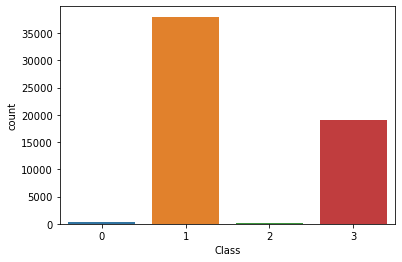

In [ ]:
sns.countplot(x = 'Class', data = classify_dataset)

역시나 불균형이지만 SMOTE 등은 진행하지 않겠습니다.

이제 Class를 Target으로 하여 decision tree를 기반으로 하는 __XGBoost Classifier__ 를 통해 학습을 시킨 뒤 <br>각각의 고객이 어느 집단에 속할지를 확률로 표현하여 **Uplift Score**를 산출하겠습니다.

In [ ]:
import sklearn
import xgboost as xgb

In [ ]:
from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
np.set_printoptions(suppress=True)
from sklearn.metrics import classification_report, accuracy_score

# set_printoptions출력의 정밀도를 설정하는 데 사용할 수 있습니다 .
# suppress : 소수에 대한 과학적 표기법의 사용을 억제합니다.

pd.options.display.float_format = '{:.5f}'.format
# pandas.option 객체 pandas.set_option() 함수를 사용하여 출력 형태를 다양하게 지정할 수 있다. 
# 예를 들어, 소수점 이하 2자리만 표현하고 싶다면 아래와 같이 할 수 있다. 
# 이때, f 혹은 e 를 사용하여 과학적 표기법을 쓸지 여부를 지정할 수 있다.

used_cols = ['recency', 'history', 'mens', 'womens', 'newbie', 'zip_code_Rural',
       'zip_code_Surburban', 'zip_code_Urban', 'history_segment_$0 - $100',
       'history_segment_$1,000 +', 'history_segment_$100 - $200',
       'history_segment_$200 - $350', 'history_segment_$350 - $500',
       'history_segment_$500 - $750', 'history_segment_$750 - $1,000',
       'channel_Multichannel', 'channel_Phone', 'channel_Web']

X = classify_dataset[used_cols]
y = classify_dataset['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [ ]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (40286, 18)
Number transactions y_train dataset:  (40286,)
Number transactions X_test dataset:  (17266, 18)
Number transactions y_test dataset:  (17266,)


**의사결정나무 모형 깊이 hyper parameter 중 max depth와 subsample를 달리해서 XGBoost 예측모형의 성능을 비교해본다.**

robust한 예측모형 구축을 위해서 훈련데이터를 __교차검증(Cross-Validation)__ 을 통해서 
<br> 과적합을 방지시킬 수 있는 모형을 구축할 수 있다.
<br> 즉 훈련데이터를 5조각을 내서 1조각을 제외한 나머지 조각을 훈련에 사용하고 모형성능을 1조각으로 평가시켜 
<br>가장 강건한 모형을 예측모형으로 선정한다.

In [ ]:
from sklearn.model_selection import GridSearchCV

# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier()

# 초모수 격자생성
xgb_param_grid = {'max_depth': [3,5,7], 
              'subsample': [0.6, 0.8, 1.0]}

# Create a GridSearchCV object
# cv = 5
hr_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='accuracy',
                       n_jobs=8,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

hr_grid.fit(X_train, y_train)

/Users/kimhoiin/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [ ]:
hr_grid_df = pd.DataFrame(hr_grid.cv_results_)
hr_grid_df.loc[:, ['mean_test_score', "params"]]

,mean_test_score,params
0,0.65911,"{'max_depth': 3, 'subsample': 0.6}"
1,0.65951,"{'max_depth': 3, 'subsample': 0.8}"
2,0.65948,"{'max_depth': 3, 'subsample': 1.0}"
3,0.65204,"{'max_depth': 5, 'subsample': 0.6}"
4,0.65375,"{'max_depth': 5, 'subsample': 0.8}"
5,0.65482,"{'max_depth': 5, 'subsample': 1.0}"
6,0.63590,"{'max_depth': 7, 'subsample': 0.6}"
7,0.64253,"{'max_depth': 7, 'subsample': 0.8}"
8,0.64938,"{'max_depth': 7, 'subsample': 1.0}"


In [ ]:
hr_grid_df[hr_grid_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,11.45268,0.25016,0.10654,0.01535,3,0.80000,"{'max_depth': 3, 'subsample': 0.8}",0.65897,0.65955,0.65881,...,0.65951,0.00065,1,0.66296,0.66279,0.66235,0.66257,0.66338,0.66281,0.00035


In [ ]:
## 최고성능
best_score = hr_grid.best_score_
# 최고성능을 내는 행을 찾아냄
best_row = hr_grid.best_index_

# 최적 초모수: max_depth, subsample
best_max_depth     = hr_grid.best_params_["max_depth"]
best_max_subsample = hr_grid.best_params_["subsample"]

nl = '\n'
print(f'예측모형성능(Accuracy):  \t {best_score:.3f}{nl}\
        인덱스:           \t {best_row}{nl}\
        max_depth:      \t {best_max_depth}{nl}\
        subsample:      \t {best_max_subsample}')

예측모형성능(Accuracy):  	 0.660
        인덱스:           	 1
        max_depth:      	 3
        subsample:      	 0.8


위의 결과에 따라서 max depth는 3으로 채택하기로 하자
<br>
sub_sample은 0.6으로 파라미터 튜닝을 하기로 하자

graphviz를 통해 xgbboost 모형 객체를 통한 **변수 중요도(feature importance)** 를 확인해보록 하자

위에서 채택된 하이퍼 파라미터를 적용해 모델을 학습시켜보자 <br> # n_estimators=100, max depth = 3, learning rate = 0.1

이 때 XGB를 이용한 다중 클래스 classification을 진행하므로 eval_metric도 그에 맞게 "mlogloss"를 선택해 loss를 minimize하는 쪽으로 분류를 진행하도록 한다.

In [ ]:
# n_estimators=100, max depth = 3, learning rate = 0.1
xgb_wrapper = xgb.XGBClassifier(n_estimators=100,max_depth=3, subsample = 0.6,learning_rate=0.1)

evals = [(X_test, y_test)]

# logloss like rank metric was not designed for multi-class classification. (다중 클래스 logloss)
# You can use the original multiclass evaluation metric, or write customized evaluation function to support this.
# multi class classification을 위해 mlogloss metric을 이용했습니다

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric ="mlogloss", eval_set = evals, verbose = True)

class_probs = xgb_wrapper.predict_proba(X_test)

[0]	validation_0-mlogloss:1.31011
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:1.24488
[2]	validation_0-mlogloss:1.18879
[3]	validation_0-mlogloss:1.13979
[4]	validation_0-mlogloss:1.09701
[5]	validation_0-mlogloss:1.05921
[6]	validation_0-mlogloss:1.02579
[7]	validation_0-mlogloss:0.99597
[8]	validation_0-mlogloss:0.96927
[9]	validation_0-mlogloss:0.94564
[10]	validation_0-mlogloss:0.92426
[11]	validation_0-mlogloss:0.90494
[12]	validation_0-mlogloss:0.88754
[13]	validation_0-mlogloss:0.87185
[14]	validation_0-mlogloss:0.85747
[15]	validation_0-mlogloss:0.84455
[16]	validation_0-mlogloss:0.83260
[17]	validation_0-mlogloss:0.82168
[18]	validation_0-mlogloss:0.81177
[19]	validation_0-mlogloss:0.80261
[20]	validation_0-mlogloss:0.79419
[21]	validation_0-mlogloss:0.78643
[22]	validation_0-mlogloss:0.77937
[23]	validation_0-mlogloss:0.77273
[24]	validation_0-mlogloss:0.76659
[25]	validation_0-mlogloss:0.76095
[26]	validation_0-mlogloss:0.7

In [ ]:
class_preds = xgb_wrapper.predict(X_test)

In [ ]:
class_preds

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
print(classification_report(y_test, class_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.66      1.00      0.80     11416
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00      5705

    accuracy                           0.66     17266
   macro avg       0.17      0.25      0.20     17266
weighted avg       0.44      0.66      0.53     17266



/Users/kimhoiin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kimhoiin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kimhoiin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
overall_proba = xgb_wrapper.predict_proba(X)

result_dataset = classify_dataset.copy()

for i in range(4):
    result_dataset[f'proba_{i}'] = overall_proba[:,i] 

result_dataset.eval('uplift_score = proba_0+proba_3-proba_1-proba_2', inplace = True)

In [ ]:
overall_proba

array([[0.00482471, 0.64285415, 0.00212492, 0.35019618],
       [0.00706838, 0.64652115, 0.00188481, 0.34452567],
       [0.00759394, 0.64011097, 0.00199539, 0.35029972],
       ...,
       [0.00570504, 0.6446272 , 0.0021399 , 0.34752786],
       [0.01434364, 0.62422174, 0.0031135 , 0.35832116],
       [0.0101197 , 0.63856244, 0.00690545, 0.3444124 ]], dtype=float32)

In [ ]:
result_dataset

,recency,history,mens,womens,newbie,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_$0 - $100,"history_segment_$1,000 +",...,treatment,target_spend,target_visit,target_conversion,Class,proba_0,proba_1,proba_2,proba_3,uplift_score
0,10.00000,142.44000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,1,0.00000,0.00000,0.00000,1,0.00482,0.64285,0.00212,0.35020,-0.28996
2,7.00000,180.65000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,1,0.00000,0.00000,0.00000,1,0.00707,0.64652,0.00188,0.34453,-0.29681
3,9.00000,675.83000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,1,0.00000,0.00000,0.00000,1,0.00759,0.64011,0.00200,0.35030,-0.28421
4,2.00000,45.34000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,...,1,0.00000,0.00000,0.00000,1,0.00645,0.65102,0.00351,0.33902,-0.30906
5,6.00000,134.83000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,1,0.00000,1.00000,0.00000,1,0.00556,0.65182,0.00240,0.34022,-0.30843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10.00000,105.54000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,1,0.00000,0.00000,0.00000,1,0.00535,0.65751,0.00220,0.33495,-0.31940
63996,5.00000,38.91000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,...,1,0.00000,0.00000,0.00000,1,0.00522,0.70332,0.00205,0.28941,-0.41073
63997,6.00000,29.99000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,...,1,0.00000,0.00000,0.00000,1,0.00571,0.64463,0.00214,0.34753,-0.29353
63998,1.00000,552.94000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,1,0.00000,0.00000,0.00000,1,0.01434,0.62422,0.00311,0.35832,-0.25467


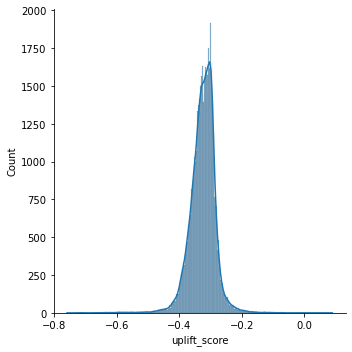

In [ ]:
sns.displot(result_dataset['uplift_score'], kde = True)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

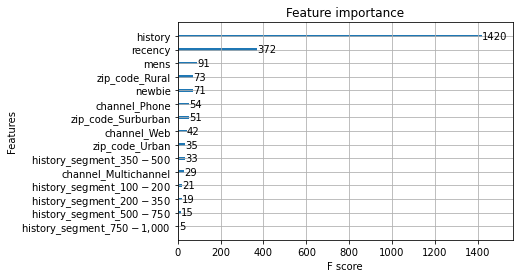

In [ ]:
xgb.plot_importance(xgb_wrapper)

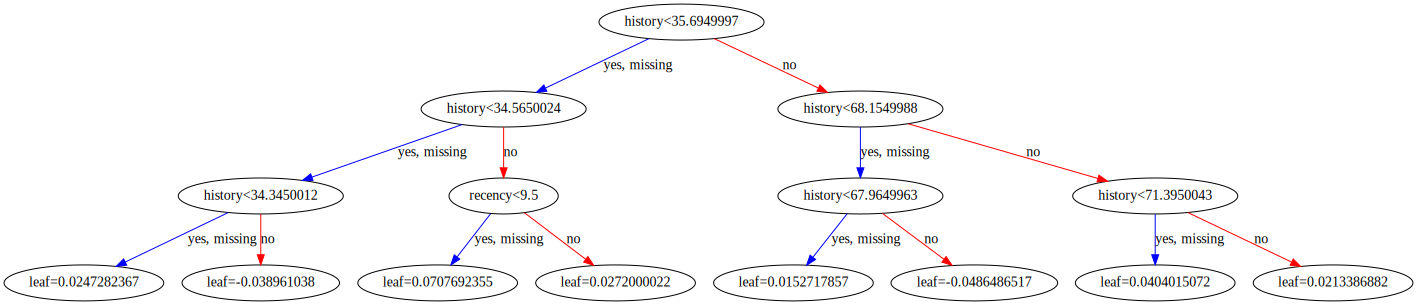

In [ ]:
xgb.to_graphviz(xgb_wrapper, num_trees=3)

# Evaluation

이제 Uplift Score가 고객들을 잘 분류해내고 있는지 평가해야합니다. <br> 사실 Uplift Model을 평가하는 것을 굉장히 어려우나 간단하게 
Uplift score 상위 25%의 고객의 ATE와 하위 25%고객의 ATE를 비교해보겠습니다. <br> 잘 분류해냈다면 상위 25% 고객의 ATE가 더 크게 나오게 될 것입니다.
<br>
각 수치를 딕셔너리로 담아 데이터프레임으로 만들어 보기 좋게 만들었습니다

In [ ]:
import pandas as pd 

In [ ]:
ate_list = {}

num = 0

def cal_uplift_eval(df):   
    
    global num 
    # 이후 계산을 위해 평균을 계산합니다.
    treatment_conv_mean = df[df.treatment == 1]['target_conversion'].mean()
    control_conv_mean = df[df.treatment == 0]['target_conversion'].mean()
    
    # 차이 계산(횟수)
    treatment_conv_ate = treatment_conv_mean - control_conv_mean
    
    # 광고를 받은 집단과 그렇지 않은 집단 간의 사이트 방문횟수의 차이를 계산합니다.
    treatment_visit = df[df.treatment == 1]['target_visit'].mean()
    control_visit = df[df.treatment == 0]['target_visit'].mean()
    
    treatment_visit_ate = treatment_visit - control_visit
    
    # 각 집단에 속한 사람들의 평균 Conversion의 차이에 각 집단이 속한 사람들이 평균적으로 
    # 지출한 금액을 곱해 광고를 받은 집단이 얼마나 더 많은 지출을 하였는지 계산합니다.
    treatment_order = treatment_conv_mean*len(df[df.treatment == 1]['target_conversion'])
    treatment_avg_spend = df[df.treatment==1]['target_spend'].mean()
    
    treatment_spend_ate = treatment_order*treatment_avg_spend
    
    print(f"Treatment Conversion ATE : {treatment_conv_ate:.03f}")
    print(f"Treatment Visit ATE : {treatment_visit_ate :.03f}")
    print(f"Treatment Spend ATE : ${treatment_spend_ate :.03f}")
    
    ate_list[num] = {'Treatment Conversion ATE': treatment_conv_ate,'Treatment Visit ATE': treatment_visit_ate, 'Treatment Spend ATE':treatment_spend_ate}
    
    num = num + 1
    
final_dataset

,recency,history,mens,womens,newbie,zip_code_Rural,zip_code_Surburban,zip_code_Urban,history_segment_$0 - $100,"history_segment_$1,000 +",...,history_segment_$350 - $500,history_segment_$500 - $750,"history_segment_$750 - $1,000",channel_Multichannel,channel_Phone,channel_Web,treatment,target_spend,target_visit,target_conversion
0,10.00000,142.44000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,2,0.00000,0.00000,0.00000
1,7.00000,180.65000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2,0.00000,0.00000,0.00000
2,9.00000,675.83000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1,0.00000,0.00000,0.00000
3,2.00000,45.34000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2,0.00000,0.00000,0.00000
4,6.00000,134.83000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,2,0.00000,1.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57547,10.00000,105.54000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1,0.00000,0.00000,0.00000
57548,5.00000,38.91000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1,0.00000,0.00000,0.00000
57549,6.00000,29.99000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1,0.00000,0.00000,0.00000
57550,1.00000,552.94000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,2,0.00000,0.00000,0.00000


In [ ]:
data_lift = result_dataset.copy()
uplift_q_75 = data_lift.uplift_score.quantile(0.75)
eval_75 = data_lift[data_lift.uplift_score >= uplift_q_75]

cal_uplift_eval(eval_75)

Treatment Conversion ATE : 0.008
Treatment Visit ATE : 0.059
Treatment Spend ATE : $174.522


In [ ]:
uplift_q_25 = data_lift.uplift_score.quantile(0.25)
eval_25 = data_lift[data_lift.uplift_score <= uplift_q_25]

cal_uplift_eval(eval_25)

Treatment Conversion ATE : 0.001
Treatment Visit ATE : 0.054
Treatment Spend ATE : $110.786


In [ ]:
ate_list

{0: {'Treatment Conversion ATE': 0.00811142862919265,
  'Treatment Visit ATE': 0.05868615356310042,
  'Treatment Spend ATE': 174.52203435500164},
 1: {'Treatment Conversion ATE': 0.0008973412305771783,
  'Treatment Visit ATE': 0.054458228248898094,
  'Treatment Spend ATE': 110.78607204777495}}

In [ ]:
df_ate = pd.DataFrame.from_dict(ate_list)
df_ate=df_ate.T
df_ate.rename(index = {0:'up q75',1:'down q25'}, inplace = True)
df_ate

,Treatment Conversion ATE,Treatment Visit ATE,Treatment Spend ATE
up q75,0.00811,0.05869,174.52203
down q25,0.00090,0.05446,110.78607


**Explanation** 
    
1. 구매 전환율을 보았을 때 상위 25%가 하위 25%보다 약 0.007 가량 높은 것을 확인 할 수 있었습니다.<br> 특히, 하위 25% 의 경우 오히려 광고를 진행했을 경우 구매 전환율이 0 이하로 나타나는 것으로 보아 광고 비용이 상위보다 거의 효과가 없을 수 있다는 것을 유추할 수 있습니다.
2. 광고 진행 시 소비 금액을 비교해보았을 때 상위 25%가 하위 25%에 비해 약 40달러 정도 높은 것을 알 수 있습니다. 
3. 광고 진행시 하위 25%가 상위 25% 보다 방문률은 미미하게 높게 나타나지만 소비금액과 구매전환율이 낮은 것을 보아 방문 시 구매로 이어지는 것은 아니라는 것을 유추할 수 있습니다.

<AxesSubplot:ylabel='Treatment Conversion ATE'>

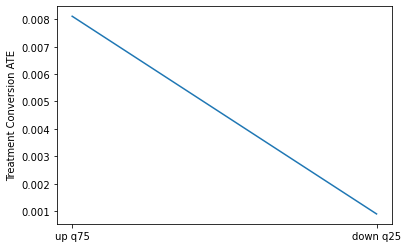

In [ ]:
sns.lineplot(data=df_ate['Treatment Conversion ATE'])

<AxesSubplot:ylabel='Treatment Visit ATE'>

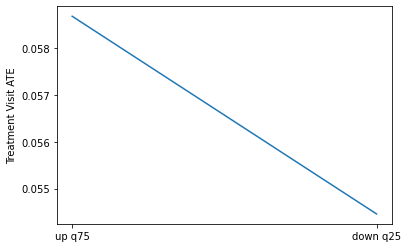

In [ ]:
sns.lineplot(data=df_ate['Treatment Visit ATE'])

<AxesSubplot:ylabel='Treatment Spend ATE'>

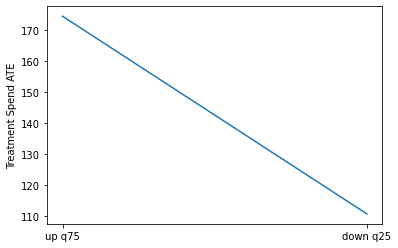

In [ ]:
sns.lineplot(data=df_ate['Treatment Spend ATE'])